### Peforming checks for the resources available

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [3]:
!pip install transformers

     |████████████████████████████████| 1.5MB 13.2MB/s 
     |████████████████████████████████| 890kB 56.6MB/s 
     |████████████████████████████████| 2.9MB 53.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=db82cd2b19bfcc5c79e834482fe4907d6aa5ef48c0cf9540e6c4dcbf797bbe8b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Importing drive into the colaboratory

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


### Importing dataset directories

In [5]:
from os import getcwd , listdir 
from os.path import join
curr_dir = getcwd()
drive_dir = join(curr_dir , 'drive','MyDrive')
dataset_dir = join(drive_dir,'Codalab','Meme Classification Challenge','Tamil_troll_memes')

In [6]:
listdir(dataset_dir)

['training_img.zip', 'train_captions.csv', 'training_img', 'labels.csv']

In [7]:
import pandas as pd
df_path = join(dataset_dir,'labels.csv')
# Load the dataset into a pandas dataframe.
df = pd.read_csv(df_path)
df.sample(10)

,imagename,captions,labels
2203,troll_356.jpg,maattukariyai vida malam suvaiyaanadhu.... ...,troll
181,Not_troll_245.jpg,poi polappa parungaiya..,Not_troll
2201,troll_354.jpg,"original yelumbichaiyai caril nasukkivittu, c...",troll
354,Not_troll_400.jpg,yenna oru villatthanam..,Not_troll
959,Not_troll_946.jpg,eppadi machi irukke! edra kaiya! aama yarra ...,Not_troll
1244,troll_1200.jpg,AMMA RATHIRIYANA THOONGU THOONGUNU THONDRAVU P...,troll
545,Not_troll_573.jpg,aama! aama! nambitom..,Not_troll
1349,troll_1297.jpg,SO LOVE.. NAMMAKITTA ADHUVAA VARANUM ..!! NAMA...,troll
2107,troll_27.jpg,Jeeva,troll
1060,troll_1035.jpg,NAANGA MATCH YENGA THOTHOM THERIYUMA..? AAH...,troll


### Extracting `sentences` and `labels` from our dataframe

In [8]:
sentences = df['captions'].values
labels = df['labels'].values

In [9]:
df['labels'].value_counts()

troll        1282
Not_troll    1018
Name: labels, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.loc[:,'labels'] = le.fit_transform(df.loc[:,'labels'])

In [11]:
df['labels'].value_counts()

1    1282
0    1018
Name: labels, dtype: int64

### Splitting the dataset into `train` , `dev` set

In [12]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences , train_labels , val_labels = train_test_split(df['captions'],df['labels'],test_size = 0.2,random_state = 42,stratify = df['labels'])

In [13]:
train_sentences

1483    IVANA VIDA IVAN DHAN DA ENNA ROMBA TORCHEL PAN...
531           vunakkulam vukkarura yedathula katti vara..
1448    *ME : NETHU NIGHT UH, NEE CHICKEN AH ALLI ALLI...
415     mandaikku mela kondai irundha matum podhadhu.....
914     aahaa track namma pakkam thirumbudhe... appadi...
                              ...                        
1730    PANDRADHAYUM PANNITU MOONJIYA EPDI VACHURUKKAN...
12       Karupu vulaipaligalin vannam.. theriuma vunakku?
2226    pattu paduravan peru paadagan na !!   arrear v...
981           ni... nidhaan...   adhukku  sariya ippa....
1307    *BOYS : IPA ETHUKU IVLO MAKEUP POTRUKINGA..?? ...
Name: captions, Length: 1840, dtype: object

In [14]:
val_sentences

1232    ACTING LEVEL KARAN ANNA : KINDNESS(ANBU) , VIC...
566                                    aiyo! semma comedy
459     yennangada mudi idhu..??  naai nakkuna maadhir...
683               romba nalla irukku thambi vun karuthu..
1682    *DOCTOR : DEI NEE ENGINEER AH  *ENGINEER : AAM...
                              ...                        
524                       idhellam oru polappa..  thuu...
600             yedukku vambu nammalun adhaiye solluvom..
159                                 yenna oru villathanam
1840    #GROUP ADMIN: WHATSAPP GROUP ADMIN REACTION WH...
1752    NELLIN AADEIYAI KALEINDHAL AARISI..  ANDHA AVA...
Name: captions, Length: 460, dtype: object

In [15]:
train_labels

1483    1
531     0
1448    1
415     0
914     0
       ..
1730    1
12      0
2226    1
981     0
1307    1
Name: labels, Length: 1840, dtype: int64

In [16]:
val_labels

1232    1
566     0
459     0
683     0
1682    1
       ..
524     0
600     0
159     0
1840    1
1752    1
Name: labels, Length: 460, dtype: int64

In [17]:
import numpy as np 
import random

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_sentences.shape[0]))

Number of training sentences: 1,840



In [18]:
label_dict = {0:'Not_troll',1:'troll'}

### Handling class imbalance using `sklearn's comput_class_weight`

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.13022113 0.89668616]


### Helper Functions

#### 1) Update Interval Function

In [19]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [21]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


#### 4) Function for calculating weighted f1 score

In [22]:
def f1_score_func(preds, labels,average):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average=average,labels = np.unique(preds_flat))

#### 5) Function for calculating accuracy per class

In [23]:
def accuracy_per_class(preds, labels , label_dict):
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

## Smart Batching of the training data

In [24]:
from transformers import AutoTokenizer

model_name = 'xlm-roberta-base'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading xlm-roberta-base tokenizer...


In [25]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))       

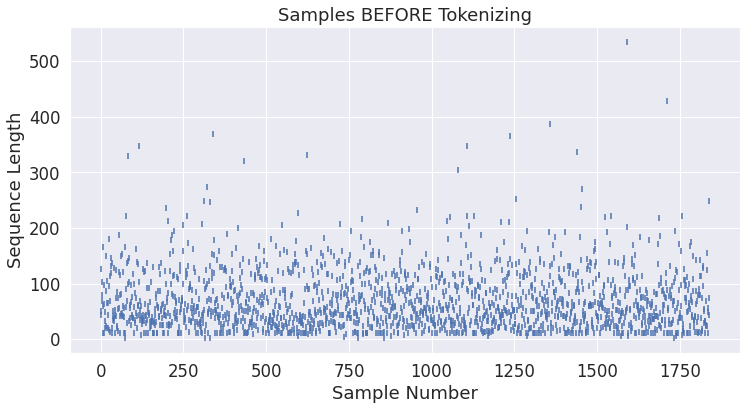

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [27]:
max_input_length = 320

In [28]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:
    
    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,           
                                 add_special_tokens=True, 
                                 max_length=max_input_length,  
                                 truncation=True,     
                                 padding=False)       
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 1,840 training samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
DONE.
     1,840 samples


In [29]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

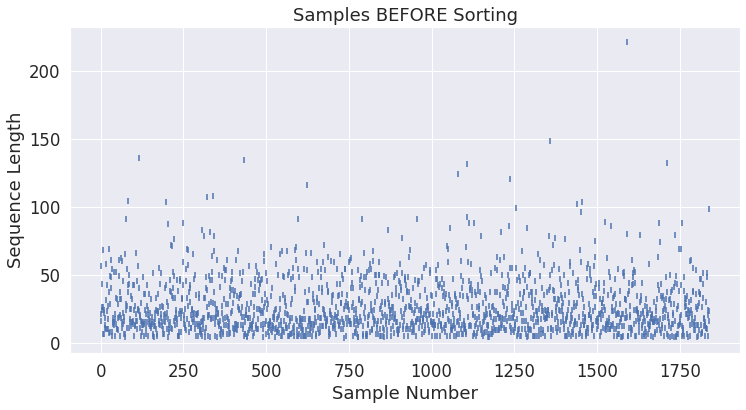

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [31]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [32]:
train_samples[0:5]

[([0, 1613, 2], 0),
 ([0, 6, 5, 2], 1),
 ([0, 110, 24626, 2], 1),
 ([0, 110, 24626, 2], 1),
 ([0, 6, 5, 2], 1)]

In [33]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 221


In [34]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

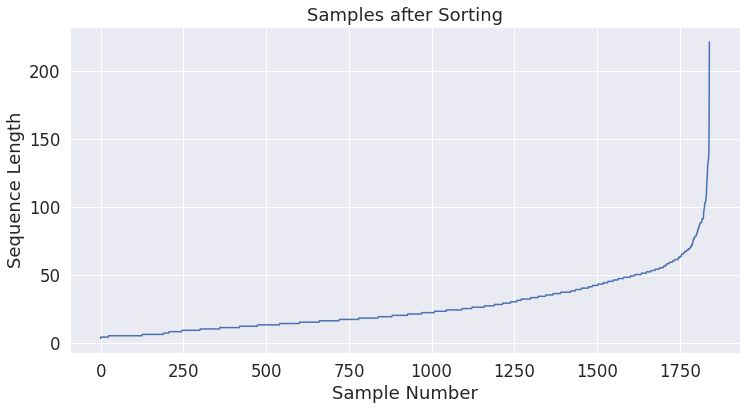

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [36]:
train_samples[0]

([0, 1613, 2], 0)

In [37]:
batch_size = 16

In [38]:
import random

# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...    
while len(train_samples) > 0:
    
    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until 
    # we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of 
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.

  DONE - 115 batches.


In [39]:
print(batch_ordered_sentences[0])

[[0, 159, 52001, 841, 222079, 839, 6, 179587, 19759, 22215, 9092, 339, 57692, 12232, 9956, 601, 33996, 12232, 9956, 391, 35746, 12232, 9956, 29227, 34388, 12232, 9956, 2], [0, 114208, 3319, 134855, 10576, 11, 28300, 221, 2631, 3000, 735, 160, 1803, 309, 84239, 14, 10576, 141, 3501, 1649, 508, 3323, 309, 187, 22890, 94562, 1405, 2], [0, 7410, 2726, 8628, 123336, 166, 2310, 11450, 4244, 14, 291, 70668, 416, 193, 34, 104414, 301, 8020, 2652, 219, 1518, 11, 2324, 6647, 34, 5, 5, 2], [0, 61745, 135486, 37672, 12048, 39037, 594, 6, 30223, 131722, 159, 14688, 6, 79347, 33261, 91877, 618, 52014, 159, 59381, 17780, 95947, 69082, 134389, 62035, 841, 11893, 2], [0, 10899, 15070, 76, 2178, 192, 6897, 24, 1165, 193, 309, 8798, 206471, 143, 27, 1613, 17, 2187, 6864, 12853, 402, 134357, 13, 2652, 48297, 5, 27, 2], [0, 241, 9254, 13242, 14, 48909, 65218, 11, 31620, 53199, 1002, 8798, 307, 1972, 50082, 435, 1132, 330, 208, 40, 143, 37604, 159906, 319, 428, 26919, 1861, 2], [0, 10, 21356, 106287, 3447, 

In [40]:
batch_ordered_labels[0]

[1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1]

### Padding

In [41]:
import torch

py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []
    
    # First, find the longest sample in the batch. 
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:
        
        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [42]:
# Get the new list of lengths after sorting.
import numpy as np
padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for s in batch:
    
        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 588,800
  Smart Batching: 56,192  (90.5% less)


#### Load the model from the transformers library using BertForSequenceClassifcation

In [43]:
from transformers import XLMRobertaForSequenceClassification

# Load the pre-trained model for classification, passing in the `config` from
# above.

model = XLMRobertaForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


print('\nModel type:', str(type(model)))


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense


Model type: <class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaForSequenceClassification'>


In [44]:
import torch
print('\nLoading model on the gpu...')
model.cuda()


Loading model on the gpu...


XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [45]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [46]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [47]:
import random
import numpy as np
import time

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the 
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)
    
    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        # compute the loss between actual and predicted values
        loss = output.loss
        logits = output.logits
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 115 batches...
  Batch      10  of      115.    Elapsed: 0:00:02.  Remaining: 0:00:24
  Batch      20  of      115.    Elapsed: 0:00:04.  Remaining: 0:00:20
  Batch      30  of      115.    Elapsed: 0:00:06.  Remaining: 0:00:17
  Batch      40  of      115.    Elapsed: 0:00:08.  Remaining: 0:00:15
  Batch      50  of      115.    Elapsed: 0:00:10.  Remaining: 0:00:13
  Batch      60  of      115.    Elapsed: 0:00:12.  Remaining: 0:00:11
  Batch      70  of      115.    Elapsed: 0:00:14.  Remaining: 0:00:09
  Batch      80  of      115.    Elapsed: 0:00:16.  Remaining: 0:00:07
  Batch      90  of      115.    Elapsed: 0:00:18.  Remaining: 0:00:05
  Batch     100  of      115.    Elapsed: 0:00:20.  Remaining: 0:00:03
  Batch     110  of      115.    Elapsed: 0:00:22.  Remaining: 0:00:01

  Average training loss: 0.42
  Training epoch took: 0:00:24

======== Epoch 2 / 4 ========
Creating Smart Batches from 1,840 examples with batch size 16...

To

#### Loading the validation data

In [48]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(val_sentences.shape[0]))

Number of training sentences: 460



In [49]:
# Use our new function to completely prepare our dataset.
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

Creating Smart Batches from 460 examples with batch size 16...

Tokenizing 460 samples...
  Tokenized 0 samples.
  Tokenized 50 samples.
  Tokenized 100 samples.
  Tokenized 150 samples.
  Tokenized 200 samples.
  Tokenized 250 samples.
  Tokenized 300 samples.
  Tokenized 350 samples.
  Tokenized 400 samples.
  Tokenized 450 samples.
DONE.
       460 samples

       460 samples after sorting

Creating batches of size 16...

  DONE - Selected 29 batches.

Padding out sequences within each batch...
  DONE.


#### Making predictions on our test dataset

In [50]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(val_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# Put model in evaluation mode
model.eval()

# For each batch of training data...
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, b_input_mask)

    logits = outputs.logits 

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 460 test sentences...
  Batch       3  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       6  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       9  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      15  of       29.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      18  of       29.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      21  of       29.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      24  of       29.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      27  of       29.    Elapsed: 0:00:01.  Remaining: 0:00:00
    DONE.


### Evaluating accuracy over test set

In [51]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.933


#### Classification report of our predictions

In [52]:
class_names =  ['Not_troll','troll']

In [53]:
from sklearn.metrics import classification_report
print(classification_report(preds,true_labels , target_names=class_names))

              precision    recall  f1-score   support

   Not_troll       0.97      0.89      0.93       221
       troll       0.91      0.97      0.94       239

    accuracy                           0.93       460
   macro avg       0.94      0.93      0.93       460
weighted avg       0.93      0.93      0.93       460



In [54]:
accuracy_per_class(predictions, true_labels , label_dict)

Class: Not_troll
Accuracy: 96.57

Class: troll
Accuracy: 90.62



In [56]:
torch.save(model,"./drive/MyDrive/Codalab/Meme Classification Challenge/Models/XLM-Roberta_Model")

In [55]:
from sklearn.metrics import f1_score
f1_score_func(predictions,true_labels,average='macro')

0.9322162804515746